# To-Dos

In [1]:
## Outlier Removal
## Time zone is Data Pull
## Cumulative Logic

# Import Packages

In [2]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [4]:
check.packages(c('RPostgreSQL', 'RJDBC', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot', 'rJava'))

RPostgreSQL       RJDBC     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      rJava 
       TRUE

In [5]:
options(scipen = 999)

# Import Data

In [61]:
## 2018-12-20 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0857.csv')

## 2010-01-01 -- Complete DL Outage
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0900.csv')

## 2019-01-04 -- Chase DL Errors
df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1130.csv')

## 2019-01-06 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1125.csv')

## 2019-01-07 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1103.csv')

## 2019-01-08 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1117.csv')

## 2019-01-11 -- Wells Fargo DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0902.csv')





df$dayofyear = as.Date(df$dayofyear)
df$grouping = as.character(df$grouping)

head(df)
str(df)

dayofyear,dayofweek,hourofday,q,bv,grouping
2018-10-04,4,0,41,24,training
2018-10-04,4,1,30,26,training
2018-10-04,4,2,35,18,training
2018-10-04,4,3,24,15,training
2018-10-04,4,4,30,19,training
2018-10-04,4,5,40,25,training


'data.frame':	2231 obs. of  6 variables:
 $ dayofyear: Date, format: "2018-10-04" "2018-10-04" ...
 $ dayofweek: int  4 4 4 4 4 4 4 4 4 4 ...
 $ hourofday: int  0 1 2 3 4 5 6 7 8 9 ...
 $ q        : int  41 30 35 24 30 40 66 98 137 151 ...
 $ bv       : int  24 26 18 15 19 25 45 75 92 118 ...
 $ grouping : chr  "training" "training" "training" "training" ...


# Clean the data

### Get Information on the "Session_Date"

In [62]:
getSessionInfo = function() {

    current.date = max(
        as.Date(df$dayofyear)
    )

    current.day = tail(
        df$dayofweek,
        1
    )

    current.hours = seq(
        from = 0,
        to = 23,
        by = 1
    )

    session.info = list(
        date = current.date,
        dow = current.day,
        hours = current.hours
    )
    
    return(session.info)
    
}

# str(getSessionInfo())
# getSessionInfo()

### Get Aggregated Data for the "Session_Date" (Test)

In [63]:
getSessionData = function() {
    
    df.session = df[which(df$grouping == 'test'), ]

    session.point.estimates = 
        df.session %>%
        group_by(
            hourofday
        ) %>%
        summarize(
            q.session = sum(q),
            dl.session = sum(bv),
            ratio.session = ifelse(
                sum(q) > 0,
                sum(bv)/sum(q),
                0
            )
        )
    
    return(session.point.estimates)
}

str(getSessionData())
# rbind(head(getSessionData(),3), tail(getSessionData(),3))
getSessionData()

Classes 'tbl_df', 'tbl' and 'data.frame':	24 obs. of  4 variables:
 $ hourofday    : int  0 1 2 3 4 5 6 7 8 9 ...
 $ q.session    : int  47 44 37 50 50 73 78 115 184 199 ...
 $ dl.session   : int  34 27 29 31 34 31 49 73 118 176 ...
 $ ratio.session: num  0.723 0.614 0.784 0.62 0.68 ...


hourofday,q.session,dl.session,ratio.session
0,47,34,0.7234043
1,44,27,0.6136364
2,37,29,0.7837838
3,50,31,0.6200000
4,50,34,0.6800000
5,73,31,0.4246575
6,78,49,0.6282051
7,115,73,0.6347826
8,184,118,0.6413043
9,199,176,0.8844221


### Get Aggregated Data for History (Training)

In [64]:
getHistoricalData = function() {

    df.hist = df[which(df$grouping == 'training'), ]

    historical.point.estimates = 
        df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
        group_by(
            hourofday
        ) %>%
        summarize(
            q.hist = sum(q),
            dl.hist = sum(bv),
            r.hist = sum(bv)/sum(q),
            n.hist = sum(q),
            sd.q.hist = sd(q),
            sd.dl.hist = sd(bv),
            mu.q.hist = mean(q),
            corr.hist = cor(q, bv),
            se.hist = sqrt(
                (
                    (
                        sd(bv)^2 + 
                        sd(q)^2 * (sum(bv)/sum(q))^2 -
                        2 * sum(bv)/sum(q) * cor(q, bv) * sd(bv) * sd(q)
                    ) /
                    (
                        sum(q) *
                        mean(q)^2
                    )
                )
            )
        )

    return(historical.point.estimates)
}

# str(getHistoricalData())
# rbind(head(getHistoricalData(),3), tail(getHistoricalData(),3))
# getHistoricalData()

# Run the bootstrap

### Construct Data Frame to store final information for ggplot.

In [65]:
df.session = getSessionData()
df.historical = getHistoricalData()

ci_information = data.frame(
    
    hour.session = df.session$hourofday,
    r.session = df.session$ratio.session,
    r.hist = df.historical$r.hist,
    se.hist = df.historical$se.hist,
    z_lower = rep(0,24),
    z_upper = rep(0,24),
    ci_lower = rep(0,24),
    ci_upper = rep(0,24)
)

ci_information

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci_lower,ci_upper
0,0.7234043,0.6500858,0.0031986165,0,0,0,0
1,0.6136364,0.6167800,0.0041586992,0,0,0,0
2,0.7837838,0.6292135,0.0066973225,0,0,0,0
3,0.6200000,0.5854271,0.0048797837,0,0,0,0
4,0.6800000,0.6332046,0.0040125621,0,0,0,0
5,0.4246575,0.6888298,0.0037745950,0,0,0,0
6,0.6282051,0.6872760,0.0012554738,0,0,0,0
7,0.6347826,0.7160350,0.0019255444,0,0,0,0
8,0.6413043,0.7216102,0.0012708006,0,0,0,0
9,0.8844221,0.7566199,0.0014906140,0,0,0,0


### Execute the Bootstrap.

In [66]:
## Set parametres and intialize.
B = 5000
bootstrap_z = vector(length = B)
alpha = 1/20

start_time = Sys.time()


## Subset the data to the DOW in question.
df.training = df[which(df$grouping == 'training'), ]
df.training.dow = df.training[which(df.training$dayofweek == getSessionInfo()$dow), ]


for (i in 1:24) {
    
    for (j in 1:B) {
      
      
    
        ## Subset the data to the current HOD (i).
        df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == i - 1), ]
    
        index = seq(
            1, 
            nrow(df.training.dow.hour)
        )
        resample_index = sample(
            x = index, 
            size = length(index), 
            replace = TRUE
        )
        df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]
      
    
        ## Calculate statistics from the resample.
        r = sum(df.training.dow.hour.resample$bv)/sum(df.training.dow.hour.resample$q)
        n = sum(df.training.dow.hour.resample$q)
        sx = sd(df.training.dow.hour.resample$q)
        sy = sd(df.training.dow.hour.resample$bv)
        mx = mean(df.training.dow.hour.resample$q)
        corr = cor(df.training.dow.hour.resample$bv, df.training.dow.hour.resample$q)
      
        se = sqrt(
            (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
            (n*mx^2)
        )
      
      
        ## Calculate statistics from the training data.
        mu = ci_information$r.hist[i]
      
      
        ## Calculate the bootstrap Z
        bootstrap_z[j] = (r - mu)/se
    }
      
    bootstrap_z = sort(bootstrap_z)
    
    ci_information$z_lower[i] = bootstrap_z[alpha/2*B]
    ci_information$z_upper[i] = bootstrap_z[(1-alpha/2)*B]
    
    ci_information$ci_lower = ci_information$r.hist - ci_information$z_upper * ci_information$se.hist
    ci_information$ci_upper = ci_information$r.hist - ci_information$z_lower * ci_information$se.hist
}

elapsed_time = Sys.time() - start_time
elapsed_time

ci_information

Time difference of 1.686735 mins

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci_lower,ci_upper
0,0.7234043,0.6500858,0.0031986165,-12.27979,19.64314,0.5872549,0.6893641
1,0.6136364,0.6167800,0.0041586992,-13.53692,11.18499,0.5702650,0.6730760
2,0.7837838,0.6292135,0.0066973225,-11.84136,11.00460,0.5555121,0.7085189
3,0.6200000,0.5854271,0.0048797837,-12.01682,10.97839,0.5318550,0.6440666
4,0.6800000,0.6332046,0.0040125621,-12.84775,13.58624,0.5786890,0.6847570
5,0.4246575,0.6888298,0.0037745950,-21.53158,14.73611,0.6332069,0.7701028
6,0.6282051,0.6872760,0.0012554738,-16.13600,31.23393,0.6480626,0.7075343
7,0.6347826,0.7160350,0.0019255444,-31.14710,21.27159,0.6750756,0.7760101
8,0.6413043,0.7216102,0.0012708006,-28.96407,29.23946,0.6844526,0.7584177
9,0.8844221,0.7566199,0.0014906140,-31.84423,30.99880,0.7104127,0.8040874


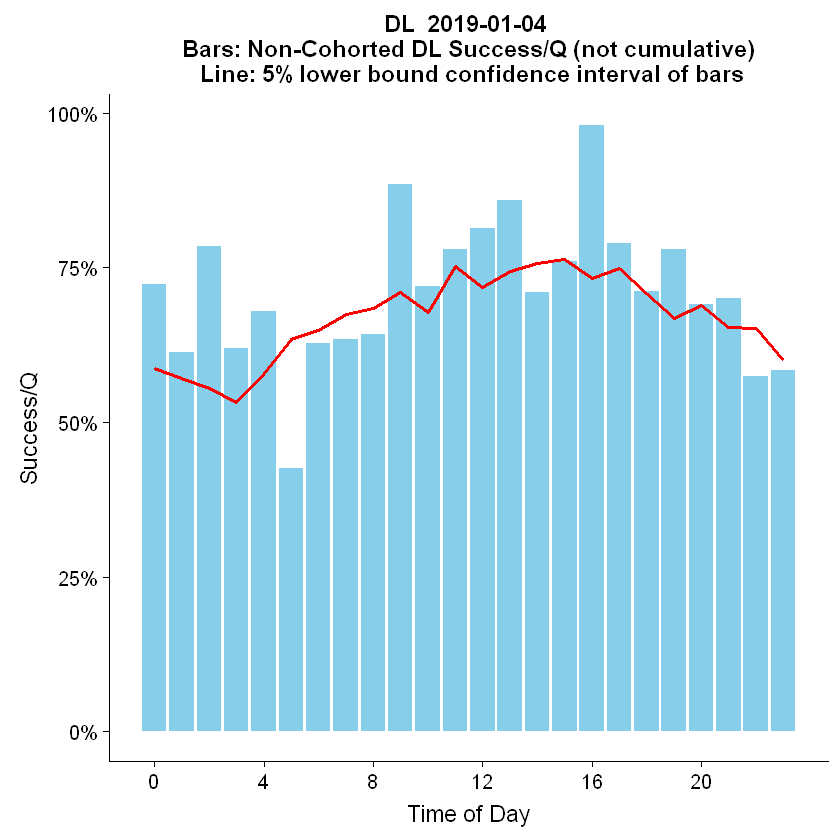

In [67]:
ggplot(
    data = ci_information, 
    mapping = aes(
        x = hour.session
    )
) +
geom_col(
    aes(y = r.session),
    fill = 'sky blue'
) + 
labs(
    x ="Time of Day", 
    y = "Success/Q", 
    title = paste(
        "DL ", getSessionInfo()$date,
        "\n", "Bars: Non-Cohorted DL Success/Q (not cumulative)", 
        "\n", "Line: 5% lower bound confidence interval of bars")
) + 
geom_line(
    aes(
        y = ci_lower
#         y = ifelse(
#             ci_lower < 0,
#             0.03 + runif(length(which(ci_lower < 0)),0,0.1),
#             ci_lower
#         )
    ), 
    color = 'red', 
    size=1
) + 
scale_y_continuous(
    labels = scales::percent 
) + 
scale_x_continuous(
    breaks = seq(0,23,4)
)# + geom_line(aes(x=hourofday, y=upper), color='springgreen4', size=1) + scale_y_continuous(labels=scales::percent) + scale_x_continuous(breaks=seq(0,23,4))
